In [1]:
from triqs.plot.mpl_interface import oplot,plt
from triqs.gf import GfImFreq, inverse, iOmega_n, SemiCircular
from h5 import HDFArchive
from sklearn.linear_model import LinearRegression
import numpy as np

## Utils

In [2]:
def fuse_eo(u):
    n = len(u)
    assert n%2==0
    m = n//2
    v = np.zeros(m,dtype=type(u[0]))
    for k in range(m-1):
        v[k] = u[2*k]+u[2*k+1]
    return v

In [3]:
def pad(u):
   n = max([len(x) for x in u])
   res = np.zeros((len(u),n))
   for i in range(len(u)):
      res[i,:len(u[i])] = u[i]
   return res

In [4]:
def mad(x):
    return np.median(np.abs(x-np.median(x)))

## Run

In [5]:
nid = 5
id0 = 0
ids = np.arange(id0,id0+nid,dtype=int)

files  = []
files2 = []

Ns  = []
Ns2 = []

beta = []
U    = []
mu   = []
mu2  = []
density   = []
density2  = []
delta  = []
delta0 = []
n_cycles = []

folder = "data"
for id in ids:
    files.append(f"{folder}/{id}solver.h5")
    files2.append(f"{folder}/{id}solver2.h5")

    with HDFArchive(files[-1],'r') as A:
        Ns.append(A['N'])
        beta.append(A['beta'])
        U.append(A['U'])
        delta.append(A['delta'])
        delta0.append(A['delta0'])
        mu.append(A['mu'])
        density.append(A['density'])
    if True:
        with HDFArchive(files2[-1],'r') as B:
            Ns2.append(B['N'])
            mu2.append(B['mu'])
            density2.append(B['density'])
            #n_cycles.append(B['n_cycles'])
            assert beta[-1] == B['beta']
            assert U[-1] == B['U']
            #assert mu[-1] == B['mu']
            assert delta[-1] == B['delta']
            #assert delta0[-1] == B['delta0']

beta = np.array(beta,dtype=float)
U    = np.array(U,   dtype=float)
#mu    = np.array(mu,   dtype=float)
delta  = np.array(delta, dtype=float)
delta0 = np.array(delta0,dtype=float)

print(f"Ns\t= {Ns}")
print(f"Ns2\t= {Ns2}")
print(f"beta\t= {beta}")
print(f"U\t= {U}")
#print(f"mu\t= {mu}")
#print(f"mu2\t= {mu2}")

print(f"delta\t= {delta}")
print(f"delta0\t= {delta0}")
#print(f"density\t= {density}")
#print(f"density2\t= {density2}")

#print(f"n_cycles\t= {n_cycles}")

ids = ids-id0

Ns	= [3, 3, 3, 3, 3]
Ns2	= [3, 3, 3, 3, 3]
beta	= [3.4 4.8 6.2 7.6 9. ]
U	= [4. 4. 4. 4. 4.]
delta	= [0.1 0.1 0.1 0.1 0.1]
delta0	= [0.738  0.7338 0.7296 0.7226 0.7296]


In [89]:
a = np.array(mu,dtype=object)
a[:,:][-1]

array([list([2.0, 4.0, 6.0, 5.8, 5.6, 5.3999999999999995, 5.199999999999999, 5.219999999999999]),
       list([2.0, 4.0, 6.0, 5.8, 5.6, 5.3999999999999995, 5.199999999999999, 4.999999999999999, 5.019999999999999, 5.039999999999998]),
       list([2.0, 4.0, 6.0, 5.8, 5.6, 5.3999999999999995, 5.199999999999999, 5.219999999999999, 5.239999999999998, 5.259999999999998, 5.279999999999998])],
      dtype=object)

In [90]:
a.shape

(5, 3)

## Time

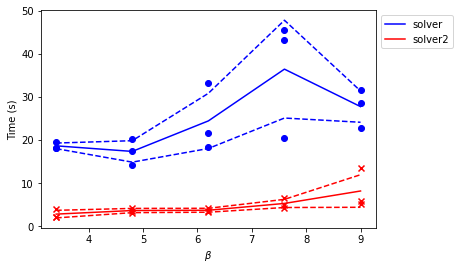

[18.67066439 17.37579521 24.45543679 36.47095593 27.77550054]
[2.82408134 3.65736381 3.72073372 5.30280987 8.19053165]


In [6]:
x = beta
xlab = "$\\beta$"
T = np.zeros(nid)
dT = np.zeros(nid)
T2 = np.zeros(nid)
dT2 = np.zeros(nid)

for id in ids:
    with HDFArchive(files[id],'r') as A:
        plt.scatter(np.full(A['t'].shape,x[id]),A['t'],color='b',marker='o')
        T[id] = A['t'].mean()
        dT[id] = np.sqrt(A['t'].var())

    with HDFArchive(files2[id],'r') as B:
        plt.scatter(np.full(B['t'].shape,x[id]),B['t'],color='r',marker='x')
        T2[id] = B['t'].mean()
        dT2[id] = np.sqrt(B['t'].var())

plt.plot(x,T,'b',label="solver")
plt.plot(x,T+dT,'b--')
plt.plot(x,T-dT,'b--')

plt.plot(x,T2,'r',label="solver2")
plt.plot(x,T2+dT2,'r--')
plt.plot(x,T2-dT2,'r--')

plt.ylabel("Time (s)")
plt.xlabel(xlab)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

print(T)
print(T2)

In [105]:
id1 = 5
x = beta
xlab = "\\beta"
T = np.zeros(nid)
T2 = np.zeros(nid)
for id in ids:
    with HDFArchive(files[id],'r') as A:
        T[id] = A['t'].mean()
    with HDFArchive(files2[id],'r') as B:
        T2[id] = B['t'].mean()
reg = LinearRegression()

reg.fit(np.log(x[id1:]).reshape(-1,1),np.log(T[id1:]).reshape(-1,1))
plt.plot(x,T,'b')
plt.plot(x[id1:],np.exp(reg.predict(np.log(x[id1:]).reshape(-1,1))),'b--')
plt.text(1,1,f"$solver: T = {np.exp(reg.intercept_[0]):.2f}{xlab}^{{ {reg.coef_[0,0]:.2f} }}$",fontsize=15,color='b',transform=plt.gcf().transFigure)

reg.fit(np.log(x[id1:]).reshape(-1,1),np.log(T2[id1:]).reshape(-1,1))
plt.plot(x,T2,'r')
plt.plot(x[id1:],np.exp(reg.predict(np.log(x[id1:]).reshape(-1,1))),'r--')
plt.text(1,0,f"$solver2: T = {np.exp(reg.intercept_[0]):.2f}{xlab}^{{ {reg.coef_[0,0]:.2f} }}$",fontsize=15,color='r',transform=plt.gcf().transFigure)

plt.ylabel("Time (s)")
plt.xlabel(f"${xlab}$")
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

## Histogram

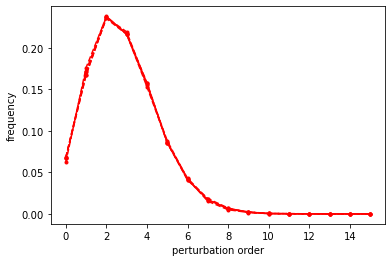

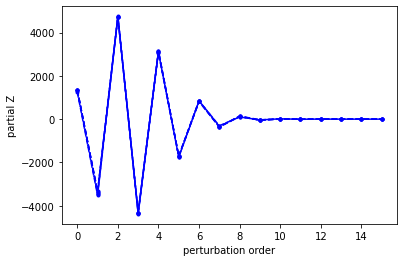

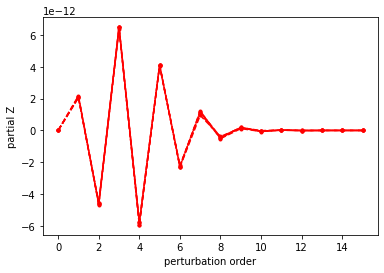

In [134]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A['hist'][i])
            k = np.arange(N)
            plt.plot(k,A['hist'][i],'r.--')
        plt.ylabel("frequency")
        plt.xlabel("perturbation order")
        plt.show()

        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N)
            plt.plot(k,A[f'hist_sign'][i].real,'b.--')
        plt.ylabel("partial Z")
        plt.xlabel("perturbation order")
        plt.show()

        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N)
            plt.plot(k,A[f'hist_sign'][i].imag,'r.--')
        plt.ylabel("partial Z")
        plt.xlabel("perturbation order")
        plt.show()

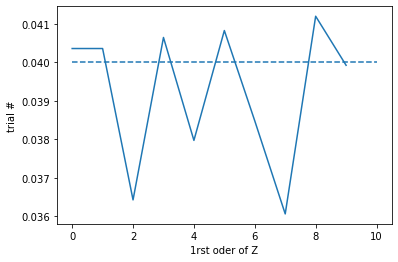

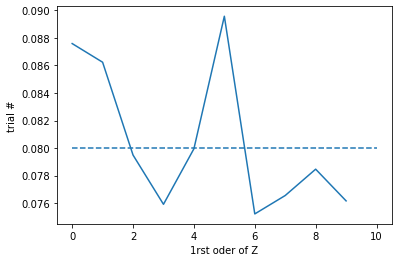

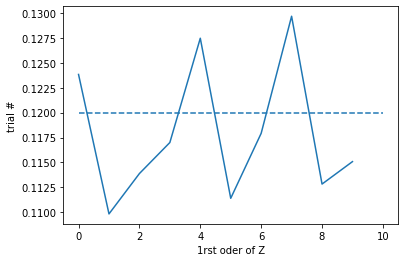

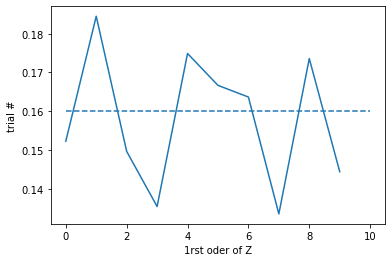

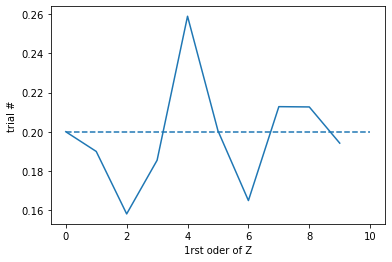

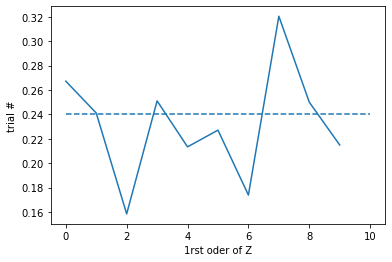

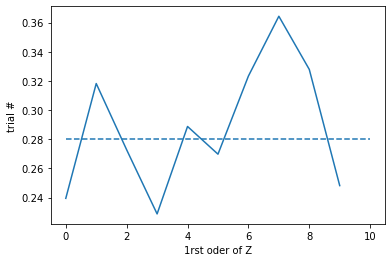

In [ ]:
for id in ids:
    g = GfImFreq(beta=beta[id],indices=[0])
    mu = U[id]/2
    half_bandwidth = 1.0
    g << inverse(iOmega_n + mu - U[id]*delta0[id] - (half_bandwidth/2.0)**2 * SemiCircular(half_bandwidth) )
    n = g.density()[0,0].real
    k = np.arange(Ns[id])
    Z1 = np.zeros(Ns[id],dtype=complex)

    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            Z1[i] = A[f"hist_sign"][i][1]/A[f"hist_sign"][i][0]

    plt.plot(k,Z1.real)
    Z1_th = -U[id]*beta[id]*(n-delta0[id]+delta[id])*(n-delta0[id]-delta[id])
    plt.hlines(Z1_th,0,Ns[id],linestyles='--') #,colors='g'
    plt.ylabel("1rst oder of Z")
    plt.xlabel("trial #")
    plt.show()

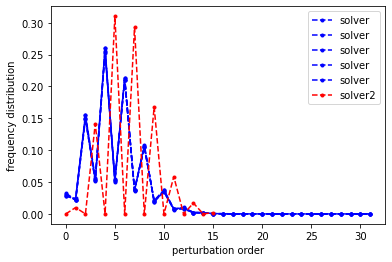

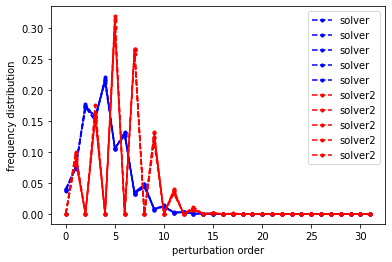

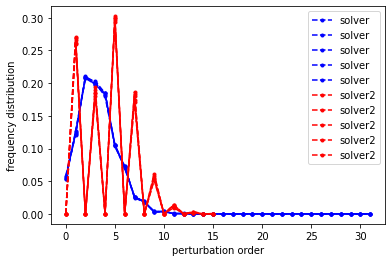

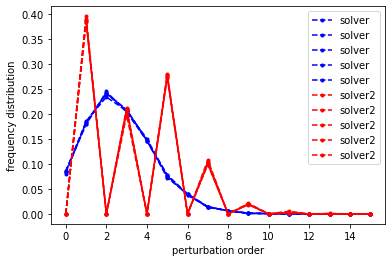

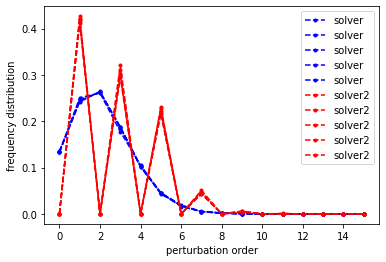

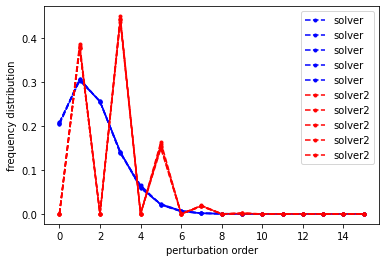

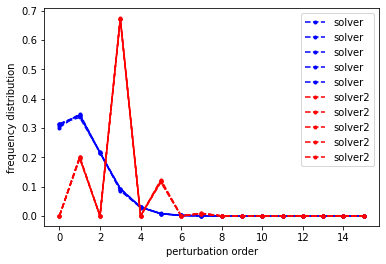

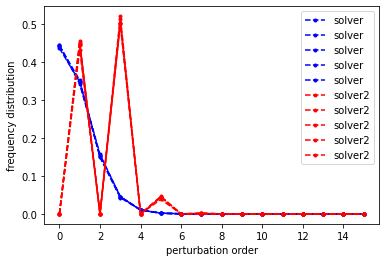

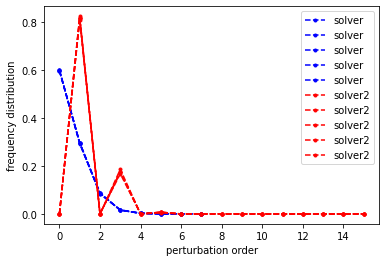

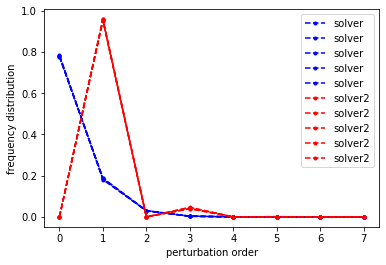

In [35]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist'][i])
            k = np.arange(N)
            plt.plot(k,A[f'hist'][i],'b.--',label="solver")

    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            N = len(B[f'hist'][i])
            k = np.arange(N)
            plt.plot(k,B[f'hist'][i],'r.--',label="solver2")
    plt.ylabel("frequency distribution")
    plt.xlabel("perturbation order")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

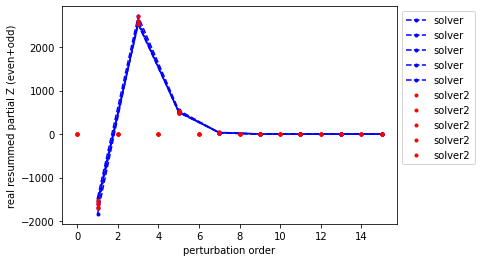

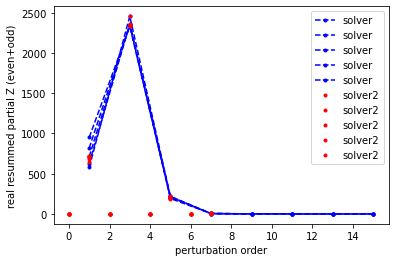

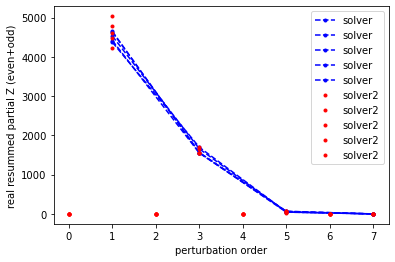

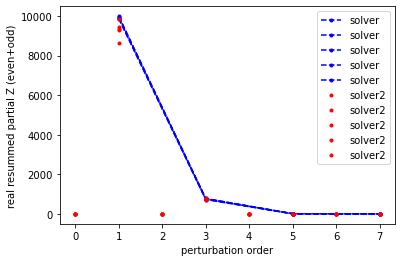

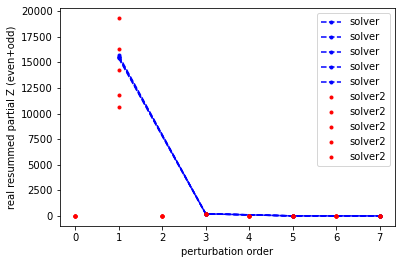

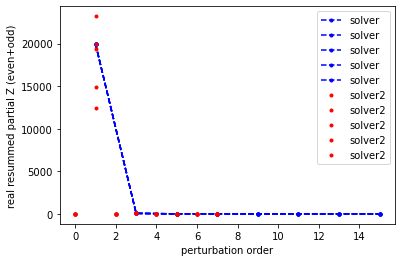

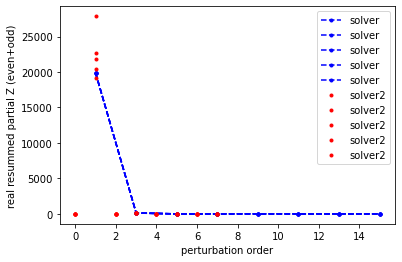

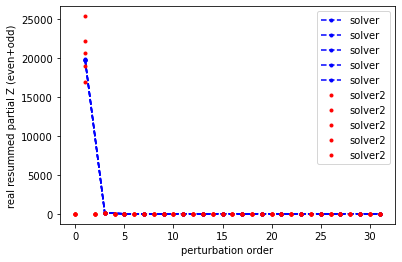

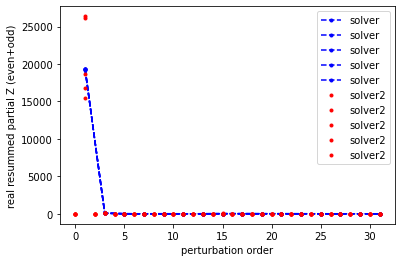

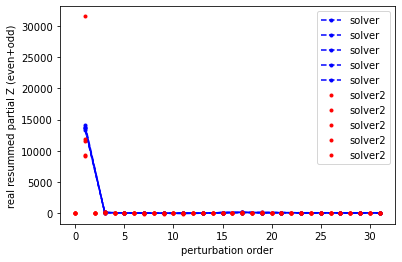

In [8]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_sign'][i])
            plt.plot(k,h.real,'b.--',label="solver")

        k0 = 3
        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_sign'][i])
                k = np.arange(N)
                if B[f'hist_sign'][i][k0] != 0 and A[f'hist_sign'][i][k0-1]+A[f'hist_sign'][i][k0] != 0:
                    h = B[f'hist_sign'][i]/B[f'hist_sign'][i][k0] * (A[f'hist_sign'][i][k0]+A[f'hist_sign'][i][k0-1])
                    plt.plot(k,h.real,'r.',label="solver2")
                else:
                    print(f"invalid {i}")
    plt.ylabel("real resummed partial Z (even+odd)")
    plt.xlabel("perturbation order")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

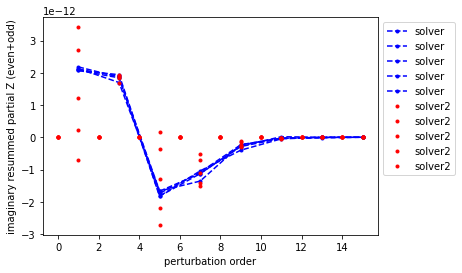

In [132]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_sign'][i])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_sign'][i])
            plt.plot(k,h.imag,'b.--',label="solver")

        k0 = 3
        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_sign'][i])
                k = np.arange(N)
                if B[f'hist_sign'][i][k0] != 0 and A[f'hist_sign'][i][k0-1]+A[f'hist_sign'][i][k0] != 0:
                    h = B[f'hist_sign'][i]/B[f'hist_sign'][i][k0] * (A[f'hist_sign'][i][k0]+A[f'hist_sign'][i][k0-1])
                    plt.plot(k,h.imag,'r.',label="solver2")
                else:
                    print(f"invalid {i}")
    plt.ylabel("imaginary resummed partial Z (even+odd)")
    plt.xlabel("perturbation order")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

## Density

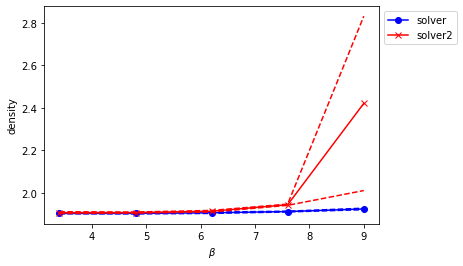

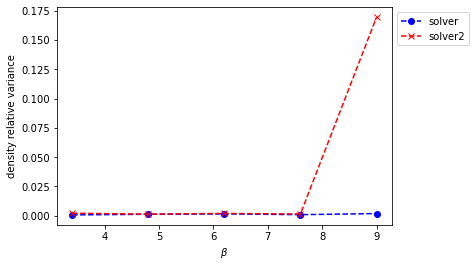

In [92]:
var = np.zeros(nid)
m = np.zeros(nid)
var2 = np.zeros(nid)
m2 = np.zeros(nid)

x = beta
xlab = "$\\beta$"
for id in ids:
    with HDFArchive(files[id],'r') as A:
            var[id] = (np.sum(A[f"n"],axis=1).real).var()
            m[id] = (np.sum(A[f"n"],axis=1).real).mean()

    with HDFArchive(files2[id],'r') as B:
            var2[id] = (np.sum(B[f"n"],axis=1).real).var()
            m2[id] = (np.sum(B[f"n"],axis=1).real).mean()
plt.plot(x,m,'bo-',label='solver')
plt.plot(x,m+np.sqrt(var),'b--')
plt.plot(x,m-np.sqrt(var),'b--')

plt.plot(x,m2,'rx-',label='solver2')
plt.plot(x,m2+np.sqrt(var2),'r--')
plt.plot(x,m2-np.sqrt(var2),'r--')

plt.ylabel("density")
plt.xlabel(xlab)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.plot(x,np.sqrt(var)/np.abs(m),'bo--',label='solver')
plt.plot(x,np.sqrt(var2)/np.abs(m2),'rx--',label='solver2')
plt.ylabel("density relative variance")
plt.xlabel(xlab)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

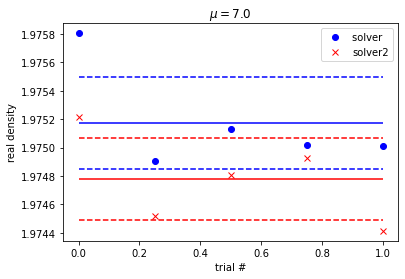

In [10]:
id = 4

k = np.linspace(0,1,Ns[id])
n = np.zeros(Ns[id],dtype=complex)
with HDFArchive(files[id],'r') as A:
    n = np.sum(A[f"n"].real,axis=1)
plt.hlines(n.mean(),0,1,color='b')
plt.hlines(n.mean()+np.sqrt(n.var()),0,1,color='b',linestyles='--')
plt.hlines(n.mean()-np.sqrt(n.var()),0,1,color='b',linestyles='--')
plt.plot(k,n,'bo',label=f"solver ")

k = np.linspace(0,1,Ns2[id])
n2 = np.zeros(Ns2[id],dtype=complex)
with HDFArchive(files2[id],'r') as B:
    n2 = np.sum(B[f"n"].real,axis=1)
plt.hlines(n2.mean(),0,1,color='r')
plt.hlines(n2.mean()+np.sqrt(n2.var()),0,1,color='r',linestyles='--')
plt.hlines(n2.mean()-np.sqrt(n2.var()),0,1,color='r',linestyles='--')
plt.plot(k,n2,'rx',label=f"solver2")

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("real density")
plt.xlabel("trial #")
plt.title(f"$\\mu = {mu[id]}$")
plt.show()

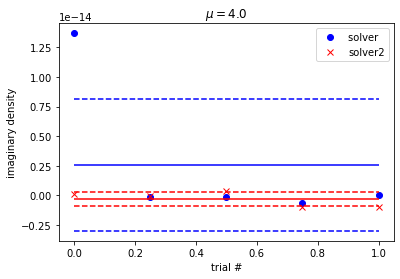

In [112]:
id = 0

k = np.linspace(0,1,Ns[id])
n = np.zeros(Ns[id],dtype=complex)
with HDFArchive(files[id],'r') as A:
    n = np.sum(A[f"n"].imag,axis=1)
plt.hlines(n.mean(),0,1,color='b')
plt.hlines(n.mean()+np.sqrt(n.var()),0,1,color='b',linestyles='--')
plt.hlines(n.mean()-np.sqrt(n.var()),0,1,color='b',linestyles='--')
plt.plot(k,n,'bo',label=f"solver ")

k = np.linspace(0,1,Ns2[id])
n2 = np.zeros(Ns2[id],dtype=complex)
with HDFArchive(files2[id],'r') as B:
    n2 = np.sum(B[f"n"].imag,axis=1)
plt.hlines(n2.mean(),0,1,color='r')
plt.hlines(n2.mean()+np.sqrt(n2.var()),0,1,color='r',linestyles='--')
plt.hlines(n2.mean()-np.sqrt(n2.var()),0,1,color='r',linestyles='--')
plt.plot(k,n2,'rx',label=f"solver2")

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("imaginary density")
plt.xlabel("trial #")
plt.title(f"$\\mu = {mu[id]}$")
#plt.ylim(-1e-10,1e-10)
plt.show()

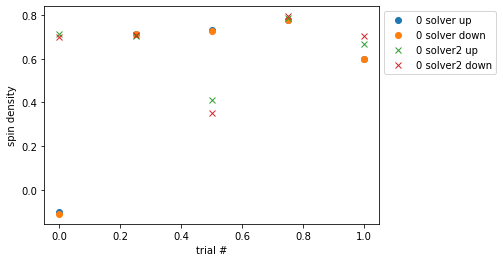

In [85]:
id = 0

k = np.linspace(0,1,Ns[id])
n = np.zeros((Ns[id],2),dtype=complex)
with HDFArchive(files[id],'r') as A:
    for i in range(Ns[id]):
        n[i] = A[f"n"][i]
plt.plot(k,n.real,'o',label=[f"{id} solver up",f"{id} solver down"])

k = np.linspace(0,1,Ns2[id])
n2 = np.zeros((Ns2[id],2),dtype=complex)
with HDFArchive(files2[id],'r') as B:
    for i in range(Ns2[id]):
        n2[i] = B[f"n"][i]
plt.plot(k,n2.real,'x',label=[f"{id} solver2 up",f"{id} solver2 down"])

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("spin density")
plt.xlabel("trial #")
plt.show()

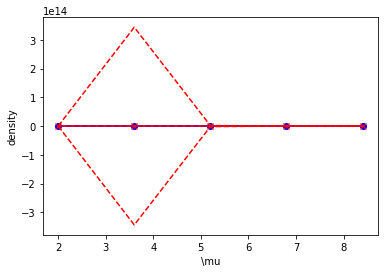

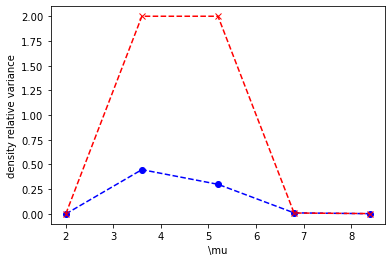

In [23]:
var = np.zeros(nid)
m = np.zeros(nid,dtype=complex)
var2 = np.zeros(nid)
m2 = np.zeros(nid,dtype=complex)

x = mu
xlab = "\\mu"
for id in ids:
    with HDFArchive(files[id],'r') as A:
            var[id] = (np.sum(A[f"n"].real,axis=1)+delta0[id]).var()
            m[id] = (np.sum(A[f"n"].real,axis=1)+delta0[id]).mean()

    with HDFArchive(files2[id],'r') as B:
            var2[id] = (np.sum(B[f"n"].real,axis=1)+delta0[id]).var()
            m2[id] = (np.sum(B[f"n"].real,axis=1)+delta0[id]).mean()
plt.plot(x,m,'bo-')
plt.plot(x,m+np.sqrt(var),'b--')
plt.plot(x,m-np.sqrt(var),'b--')

plt.plot(x,m2,'rx-')
plt.plot(x,m2+np.sqrt(var2),'r--')
plt.plot(x,m2-np.sqrt(var2),'r--')

plt.ylabel("density")
plt.xlabel(xlab)
plt.show()

plt.plot(x,np.sqrt(var)/np.abs(m),'bo--')
plt.plot(x,np.sqrt(var2)/np.abs(m2),'rx--')
plt.ylabel("density relative variance")
plt.xlabel(xlab)
plt.show()

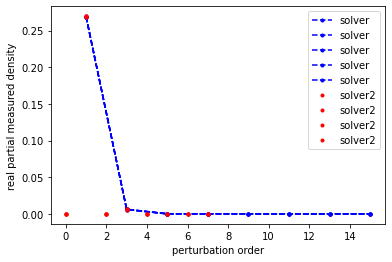

In [24]:
id = 0
with HDFArchive(files[id],'r') as A:
    for i in range(Ns[id]):
        N = len(A[f'hist_n'][i])
        k = np.arange(N//2)*2+1
        h = fuse_eo(A[f'hist_n'][i])
        plt.plot(k,h.real,'b.--',label='solver')

    with HDFArchive(files2[id],'r') as B:
        for i in range(1,Ns2[id]):
            N = len(B[f'hist_n'][i])
            k = np.arange(N)
            h = B[f'hist_n'][i]
            plt.plot(k,h.real,'r.',label='solver2')
plt.ylabel("real partial measured density")
plt.xlabel("perturbation order")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

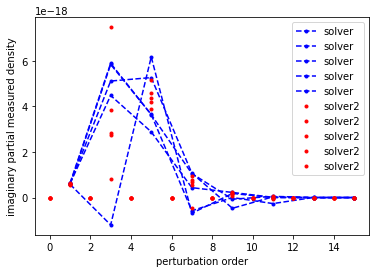

In [146]:
id=0
with HDFArchive(files[id],'r') as A:
    for i in range(Ns[id]):
        N = len(A[f'hist_n'][i])
        k = np.arange(N//2)*2+1
        h = fuse_eo(A[f'hist_n'][i])
        plt.plot(k,h.imag,'b.--',label='solver')

    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            N = len(B[f'hist_n'][i])
            k = np.arange(N)
            h = B[f'hist_n'][i]
            plt.plot(k,h.imag,'r.',label='solver2')
plt.ylabel("imaginary partial measured density")
plt.xlabel("perturbation order")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

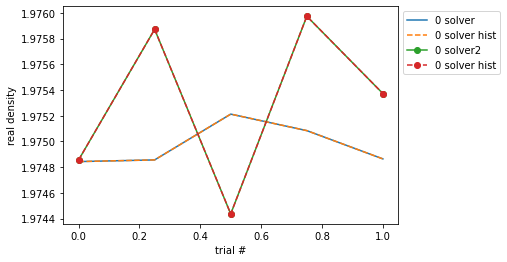

In [23]:
id=0
k = np.linspace(0,1,Ns[id])
n = np.zeros(Ns[id],dtype=complex)
n_hist = np.zeros(Ns[id],dtype=complex)
with HDFArchive(files[id],'r') as A:
    n = np.sum(A[f"n"],axis=1)
    n_hist = np.sum(A[f"hist_n"],axis=1)+2*delta0[id]
plt.plot(k,n.real,label=f"{id} solver")
plt.plot(k,n_hist.real,'--',label=f"{id} solver hist")

k = np.linspace(0,1,Ns2[id])
n2 = np.zeros(Ns2[id],dtype=complex)
n_hist2 = np.zeros(Ns2[id],dtype=complex)
with HDFArchive(files2[id],'r') as B:
    n2 = np.sum(B[f"n"],axis=1)
    n_hist2 = np.sum(B[f"hist_n"],axis=1)+2*delta0[id]
plt.plot(k,n2.real,'o-',label=f"{id} solver2")
plt.plot(k,n_hist2.real,'o--',label=f"{id} solver hist")

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("real density")
plt.xlabel("trial #")
plt.show()

## Double Occupancy

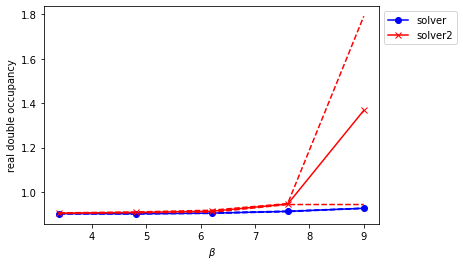

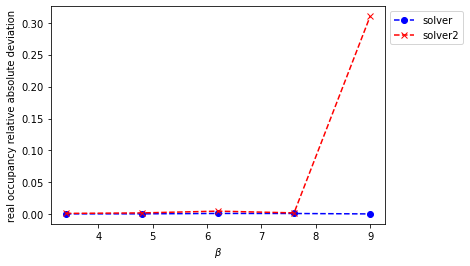

In [93]:
m = np.zeros(nid)
dd = np.zeros(nid)
m2 = np.zeros(nid)
dd2 = np.zeros(nid)

for id in ids:
    with HDFArchive(files[id],'r') as A:
            d = A[f"d"].real
            m[id] = np.median(d)
            dd[id] = mad(d)

    with HDFArchive(files2[id],'r') as B:
            d2 = B[f"d"].real
            m2[id] = np.median(d2)
            dd2[id] = mad(d2)

x = beta
xlab = "$\\beta$"
plt.plot(x,m,'bo-',label="solver")
plt.plot(x,m+dd,'b--')
plt.plot(x,m-dd,'b--')

plt.plot(x,m2,'rx-',label="solver2")
plt.plot(x,m2+dd2,'r--')
plt.plot(x,m2-dd2,'r--')

plt.ylabel("real double occupancy")
plt.xlabel(xlab)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.plot(x,dd/np.abs(m),'bo--',label="solver")
plt.plot(x,dd2/np.abs(m2),'rx--',label="solver2")
plt.ylabel("real occupancy relative absolute deviation")
plt.xlabel(xlab)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

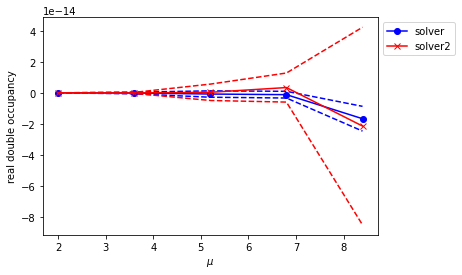

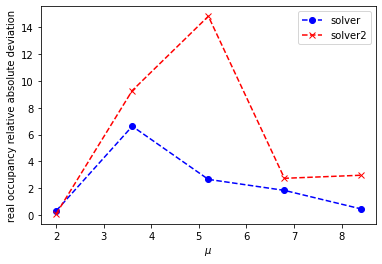

In [166]:
m = np.zeros(nid)
dd = np.zeros(nid)
m2 = np.zeros(nid)
dd2 = np.zeros(nid)

for id in ids:
    with HDFArchive(files[id],'r') as A:
            d = A[f"d"].imag
            m[id] = np.median(d)
            dd[id] = mad(d)

    with HDFArchive(files2[id],'r') as B:
            d2 = B[f"d"].imag
            m2[id] = np.median(d2)
            dd2[id] = mad(d2)

x = mu
xlab = "$\\mu$"
plt.plot(x,m,'bo-',label="solver")
plt.plot(x,m+dd,'b--')
plt.plot(x,m-dd,'b--')

plt.plot(x,m2,'rx-',label="solver2")
plt.plot(x,m2+dd2,'r--')
plt.plot(x,m2-dd2,'r--')

plt.ylabel("real double occupancy")
plt.xlabel(xlab)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

plt.plot(x,dd/np.abs(m),'bo--',label="solver")
plt.plot(x,dd2/np.abs(m2),'rx--',label="solver2")
plt.ylabel("real occupancy relative absolute deviation")
plt.xlabel(xlab)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

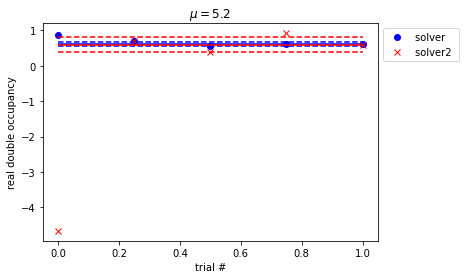

In [162]:
id = 2

k = np.linspace(0,1,Ns[id])
d = np.zeros(Ns[id])
with HDFArchive(files[id],'r') as A:
    d = A[f"d"].real
    m = np.median(d)
    dd = mad(d)
plt.hlines(m,0,1,color='b')
plt.hlines(m+dd,0,1,color='b',linestyles='--')
plt.hlines(m-dd,0,1,color='b',linestyles='--')
plt.plot(k,d,'bo',label=f"solver ")

k = np.linspace(0,1,Ns[id])
d2 = np.zeros(Ns2[id])
with HDFArchive(files2[id],'r') as B:
    d2 = B[f"d"].real
    m2 = np.median(d2)
    dd2 = mad(d2)
plt.hlines(m2,0,1,color='r')
plt.hlines(m2+dd2,0,1,color='r',linestyles='--')
plt.hlines(m2-dd2,0,1,color='r',linestyles='--')
plt.plot(k,d2,'rx',label=f"solver2 ")

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("real double occupancy")
plt.xlabel("trial #")
plt.title(f"$\\mu = {mu[id]}$")
plt.show()

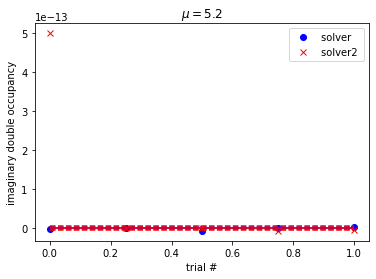

In [163]:
id = 2

k = np.linspace(0,1,Ns[id])
d = np.zeros(Ns[id])
with HDFArchive(files[id],'r') as A:
    d = A[f"d"].imag
    m = np.median(d)
    dd = mad(d)
plt.hlines(m,0,1,color='b')
plt.hlines(m+dd,0,1,color='b',linestyles='--')
plt.hlines(m-dd,0,1,color='b',linestyles='--')
plt.plot(k,d,'bo',label=f"solver ")

k = np.linspace(0,1,Ns[id])
d2 = np.zeros(Ns2[id])
with HDFArchive(files2[id],'r') as B:
    d2 = B[f"d"].imag
    m2 = np.median(d2)
    dd2 = mad(d2)
plt.hlines(m2,0,1,color='r')
plt.hlines(m2+dd2,0,1,color='r',linestyles='--')
plt.hlines(m2-dd2,0,1,color='r',linestyles='--')
plt.plot(k,d2,'rx',label=f"solver2 ")

plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("imaginary double occupancy")
plt.xlabel("trial #")
plt.title(f"$\\mu = {mu[id]}$")
plt.show()

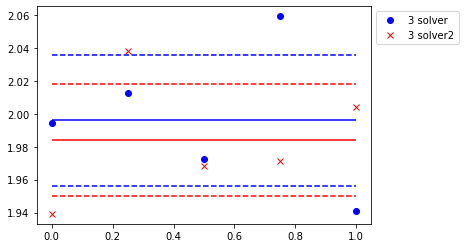

In [44]:
id1 = 0
for id in [id1]:
    k = np.linspace(0,1,Ns[id])
    d = np.zeros(Ns[id],dtype=complex)
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            d[i] = A[f"d"][i]+(delta0[id])*np.sum(A[f"n"][i])+delta0[id]**2+delta[id]**2

    plt.hlines(d.real.mean(),0,1,color='b')
    plt.hlines(d.real.mean()+np.sqrt(d.var()),0,1,color='b',linestyles='--')
    plt.hlines(d.real.mean()-np.sqrt(d.var()),0,1,color='b',linestyles='--')
    plt.plot(k,d.real,'bo',label=f"{id} solver")

    k = np.linspace(0,1,Ns2[id])
    d2 = np.zeros(Ns2[id],dtype=complex)
    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            d2[i] = B[f"d"][i]+(delta0[id])*np.sum(B[f"n"][i])+delta0[id]**2+delta[id]**2

    plt.hlines(d2.real.mean(),0,1,color='r')
    plt.hlines(d2.real.mean()+np.sqrt(d2.var()),0,1,color='r',linestyles='--')
    plt.hlines(d2.real.mean()-np.sqrt(d2.var()),0,1,color='r',linestyles='--')
    plt.plot(k,d2.real,"rx",label=f"{id} solver2")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (5,)

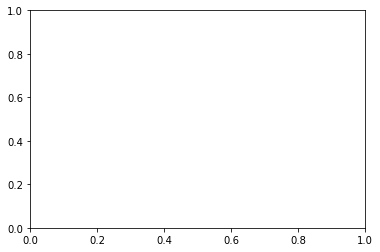

In [45]:
var = np.zeros(nid)
m = np.zeros(nid,dtype=complex)
var2 = np.zeros(nid)
m2 = np.zeros(nid,dtype=complex)

for id in ids:
    with HDFArchive(files[id],'r') as A:
            var[id] = (A[f"d"]+(delta0[id])*np.sum(A[f"n"],axis=1)+delta0[id]**2+delta[id]**2).var()
            m[id] = (A[f"d"]+(delta0[id])*np.sum(A[f"n"],axis=1)+delta0[id]**2+delta[id]**2).mean()

    with HDFArchive(files2[id],'r') as B:
            var2[id] = (B[f"d"]+(delta0[id])*np.sum(B[f"n"],axis=1)+delta0[id]**2+delta[id]**2).var()
            m2[id] = (B[f"d"]+(delta0[id])*np.sum(B[f"n"],axis=1)+delta0[id]**2+delta[id]**2).mean()

x = n_cycles
xlab = "n_cycles"
plt.plot(x,m.real,'bo-')
plt.plot(x,m.real+np.sqrt(var),'b--')
plt.plot(x,m.real-np.sqrt(var),'b--')

plt.plot(x,m2.real,'rx-')
plt.plot(x,m2.real+np.sqrt(var2),'r--')
plt.plot(x,m2.real-np.sqrt(var2),'r--')

plt.ylabel("double occupancy")
plt.xlabel(xlab)
plt.show()

plt.plot(x,np.sqrt(var)/np.abs(m),'bo--')
plt.plot(x,np.sqrt(var2)/np.abs(m2),'rx--')
plt.ylabel("double occupancy relative variance")
plt.xlabel(xlab)
plt.show()

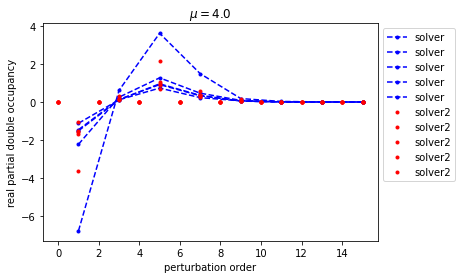

In [120]:
id=0
with HDFArchive(files[id],'r') as A:
    for i in range(Ns[id]):
        N = len(A[f'hist_d'][i])
        k = np.arange(N//2)*2+1
        h = fuse_eo(A[f'hist_d'][i])
        plt.plot(k,h.real,'b.--',label="solver")

    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            N = len(B[f'hist_d'][i])
            k = np.arange(N)
            h = B[f'hist_d'][i]
            plt.plot(k,h.real,'r.',label="solver2")
plt.ylabel("real partial double occupancy")
plt.xlabel("perturbation order")
plt.legend(bbox_to_anchor=(1,1))
plt.title(f"$\\mu = {mu[id]}$")
plt.show()

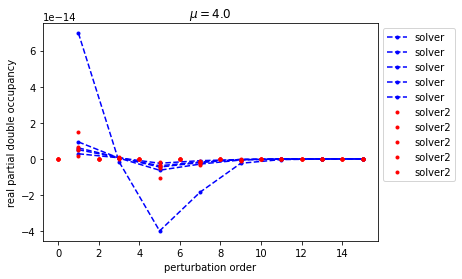

In [119]:
id=0
with HDFArchive(files[id],'r') as A:
    for i in range(Ns[id]):
        N = len(A[f'hist_d'][i])
        k = np.arange(N//2)*2+1
        h = fuse_eo(A[f'hist_d'][i])
        plt.plot(k,h.imag,'b.--',label="solver")

    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            N = len(B[f'hist_d'][i])
            k = np.arange(N)
            h = B[f'hist_d'][i]
            plt.plot(k,h.imag,'r.',label="solver2")
plt.ylabel("real partial double occupancy")
plt.xlabel("perturbation order")
plt.legend(bbox_to_anchor=(1,1))
plt.title(f"$\\mu = {mu[id]}$")
plt.show()

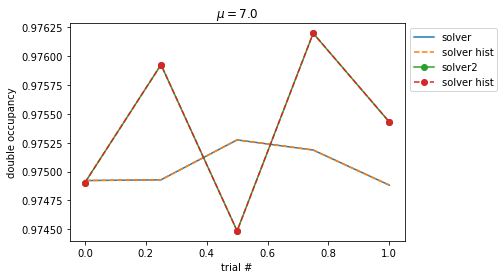

In [22]:
id = 0
k = np.linspace(0,1,Ns[id])
d = np.zeros(Ns[id],dtype=complex)
d_hist = np.zeros(Ns[id],dtype=complex)
with HDFArchive(files[id],'r') as A:
    d = A[f"d"]
    d_hist = np.sum(A[f"hist_d"],axis=1)+np.sum(A[f"n"],axis=1)*delta0[id]-(delta0[id]**2-delta[id]**2)
plt.plot(k,d.real,label=f"solver")
plt.plot(k,d_hist.real,'--',label=f"solver hist")

k = np.linspace(0,1,Ns2[id])
d2 = np.zeros(Ns2[id],dtype=complex)
d_hist2 = np.zeros(Ns2[id],dtype=complex)
with HDFArchive(files2[id],'r') as B:
    d2 = B[f"d"]
    d_hist2 = np.sum(B[f"hist_d"],axis=1)+np.sum(B[f"n"],axis=1)*delta0[id]-(delta0[id]**2-delta[id]**2)
plt.plot(k,d2.real,'o-',label=f"solver2")
plt.plot(k,d_hist2.real,'o--',label=f"solver hist")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("trial #")
plt.ylabel("double occupancy")
plt.title(f"$\\mu = {mu[id]}$")
plt.show()

## $M(i\omega_n)$

In [ ]:
Nom = 10 # # of Matsubara frequencies

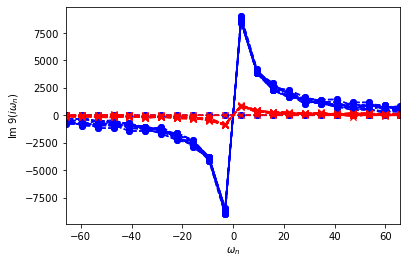

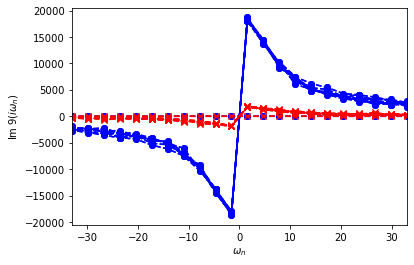

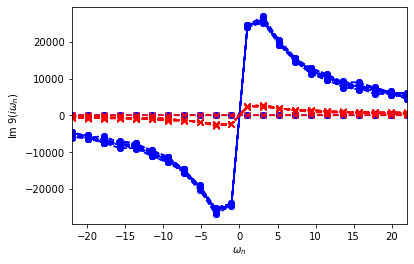

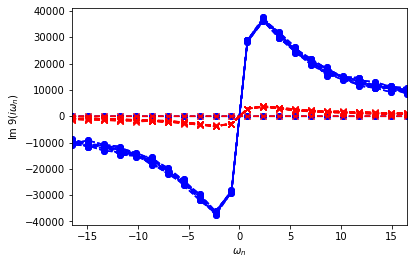

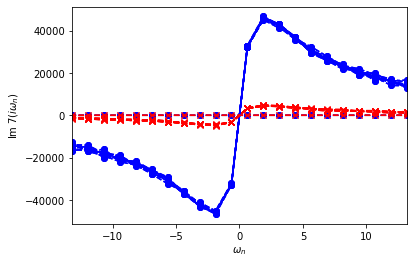

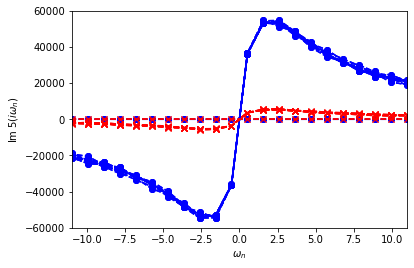

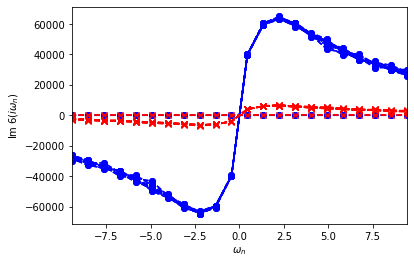

In [ ]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'M_iw'][i].imag, 'bo--')

    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'M_iw'][i].imag, 'rx--')
            
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

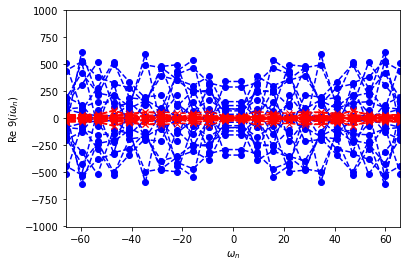

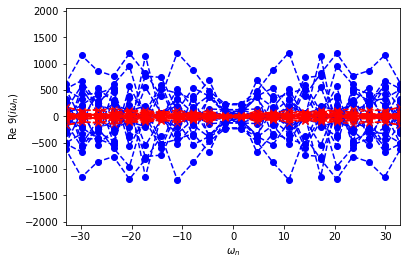

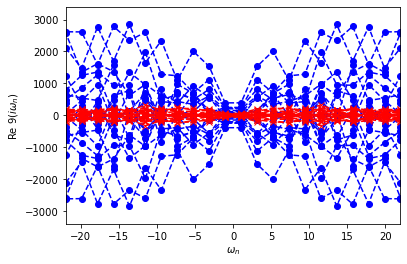

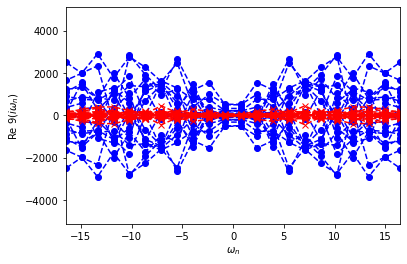

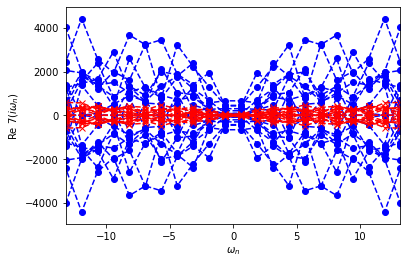

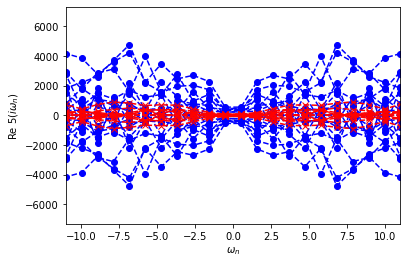

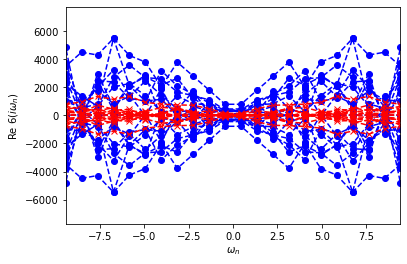

In [ ]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'M_iw'][i].real, 'bo--')

    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'M_iw'][i].real, 'rx--')
            
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

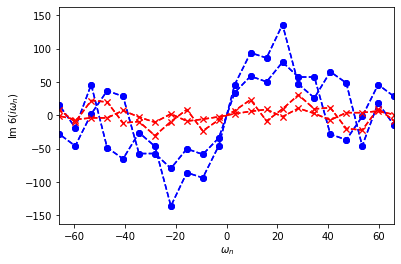

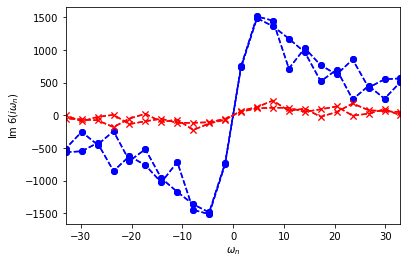

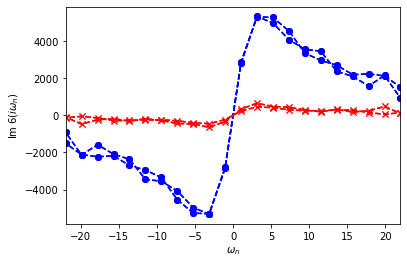

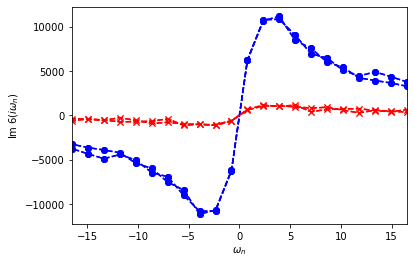

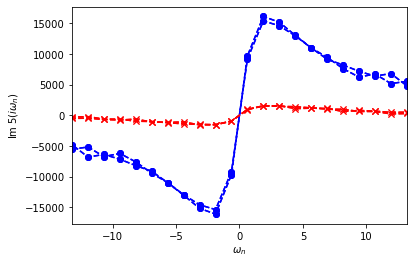

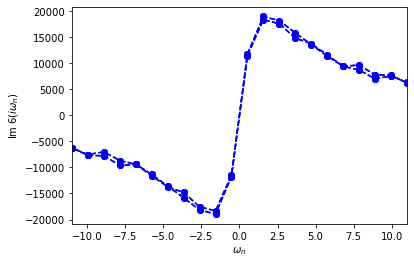

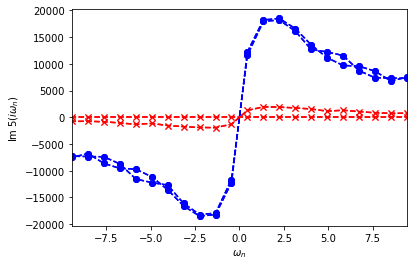

In [ ]:
k0 = 5

for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            if A[f'k'][i]==k0:
                oplot(A[f'Mk_iw'][i].imag, 'bo--')
    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            if B[f'k'][i]==k0:
                oplot(B[f'Mk_iw'][i].imag, 'rx--')
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

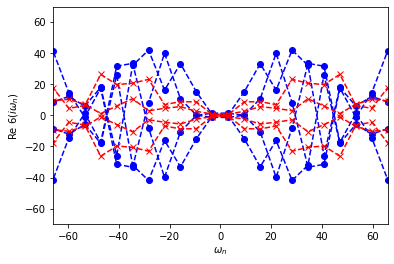

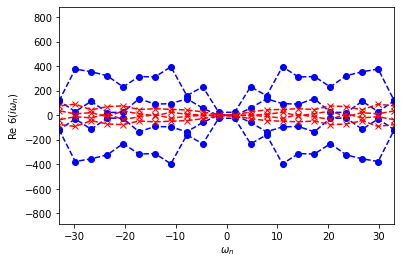

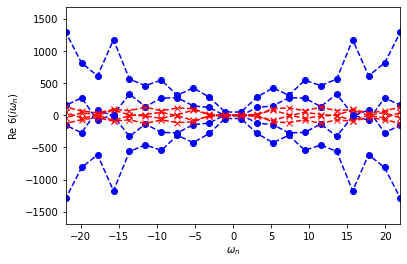

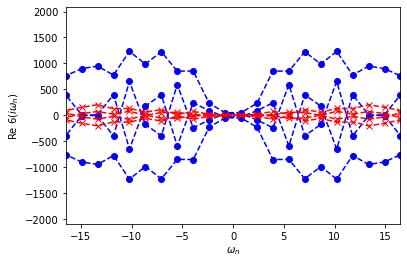

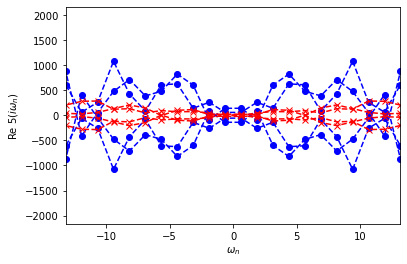

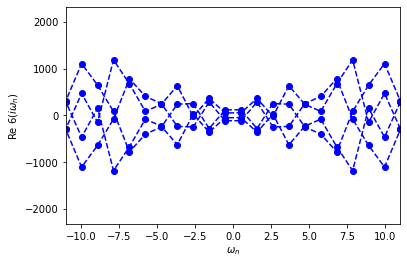

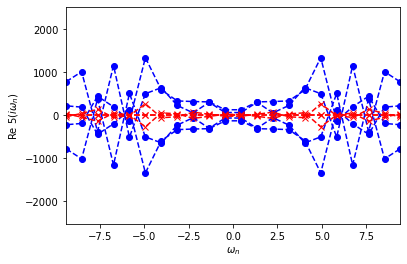

In [ ]:
k0 = 5

for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            if A[f'k'][i]==k0:
                oplot(A[f'Mk_iw'][i].real, 'bo--')
    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            if B[f'k'][i]==k0:
                oplot(B[f'Mk_iw'][i].real, 'rx--')
    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

## GF

In [ ]:
Nom = 10 # # of Matsubara frequencies

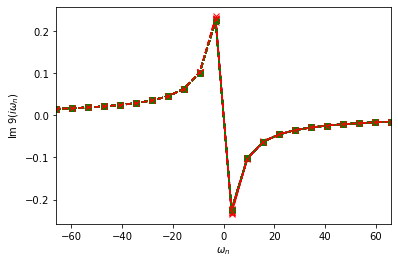

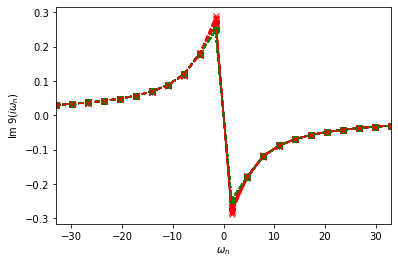

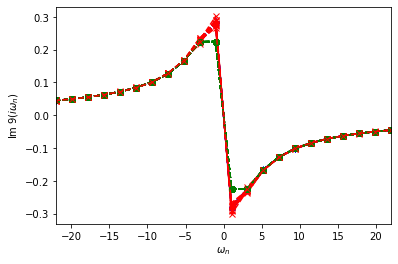

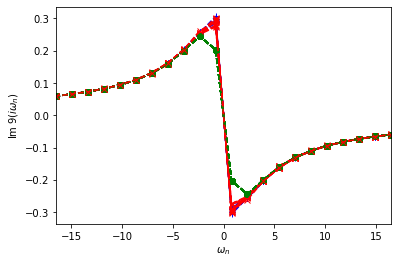

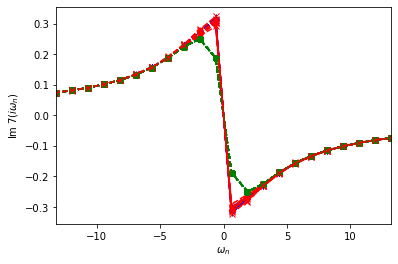

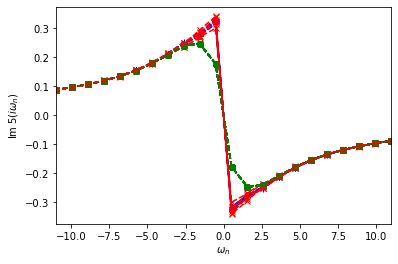

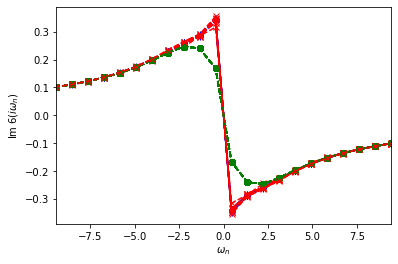

In [ ]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G0_iw'][i].imag, 'go--')
            oplot(A[f'G_iw'][i].imag, 'b+--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G0_iw'][i].imag, 'go--')
            oplot(B[f'G_iw'][i].imag, 'rx--')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

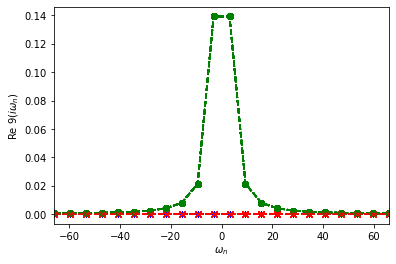

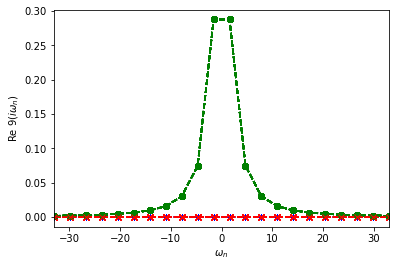

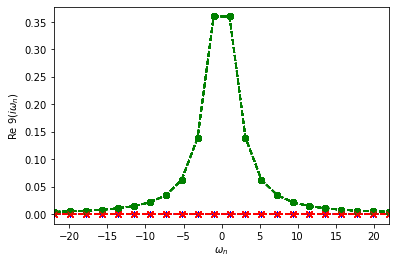

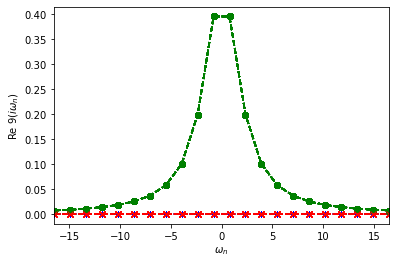

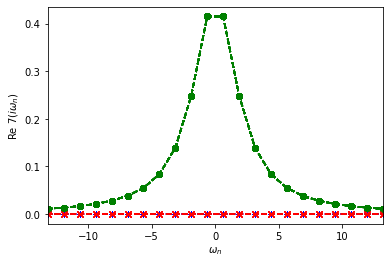

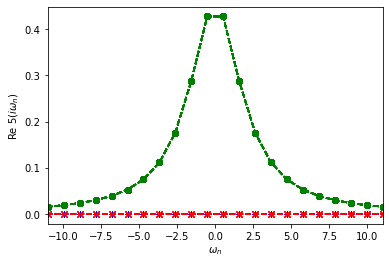

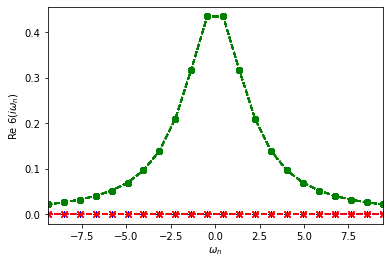

In [ ]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G0_iw'][i].real, 'go--')
            oplot(A[f'G_iw'][i].real, 'b+--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G0_iw'][i].real, 'go--')
            oplot(B[f'G_iw'][i].real, 'rx--')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

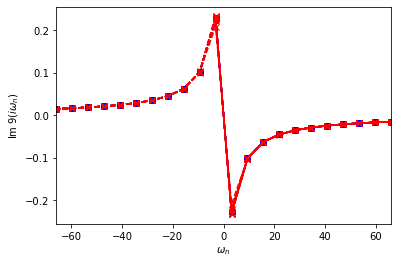

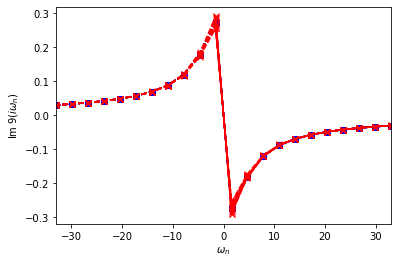

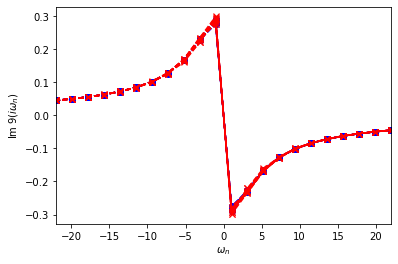

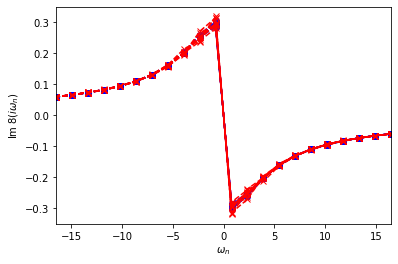

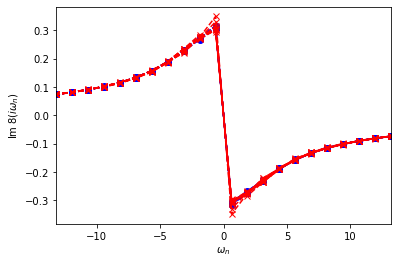

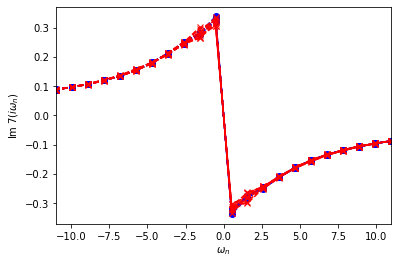

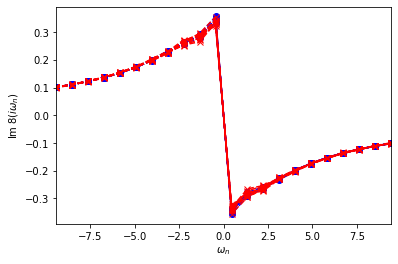

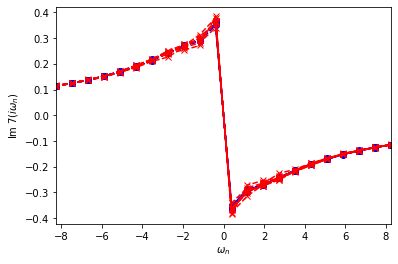

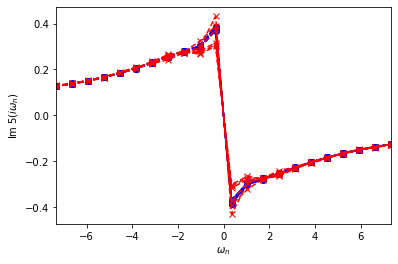

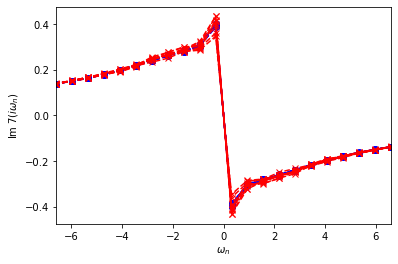

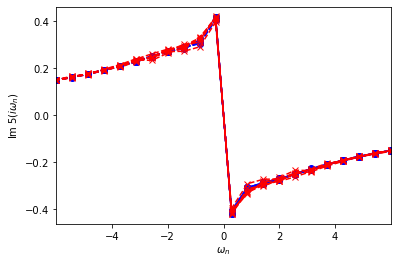

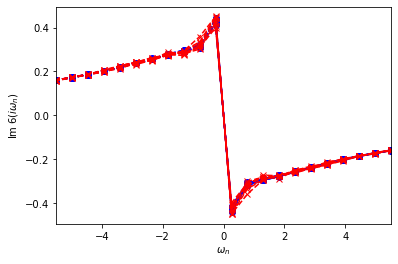

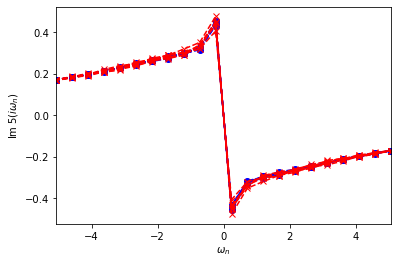

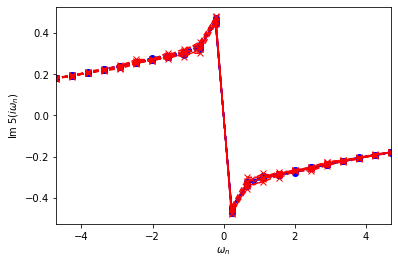

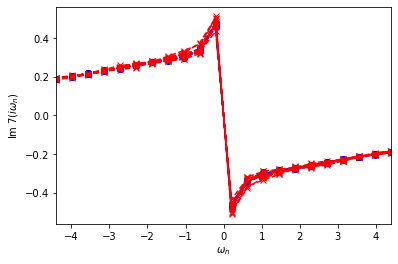

In [ ]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G_iw'][i].imag, 'bo--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G_iw'][i].imag, 'rx--')

    plt.xlim(-xm,xm)

    plt.legend().remove()
    plt.show()

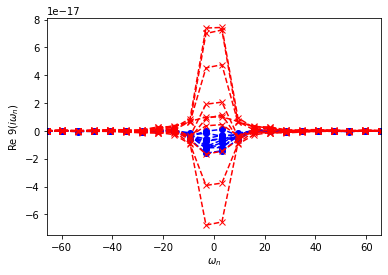

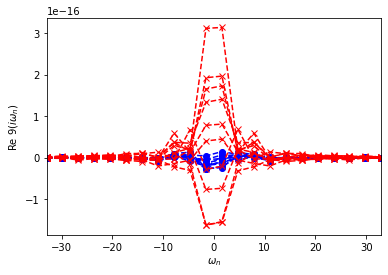

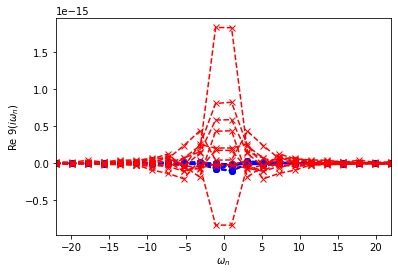

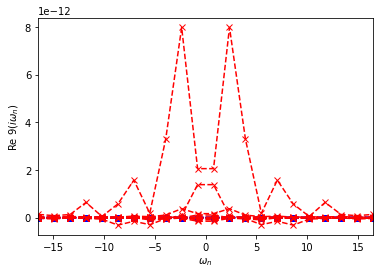

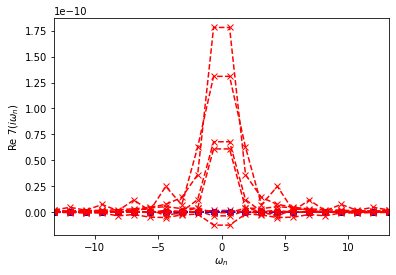

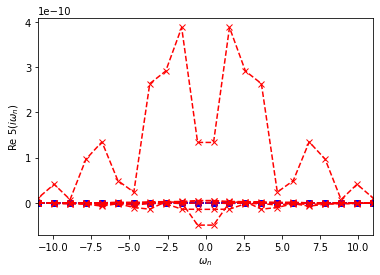

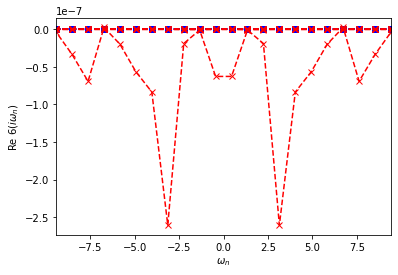

In [ ]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G_iw'][i].real, 'bo--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(B[f'N']):
            oplot(B[f'G_iw'][i].real, 'rx--')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

## End